# Problem 3
by Mainka Adrien, Sghir Hamza and Dehgan Arthur

In [1]:
from itertools import product
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.utils.data as utils
from matplotlib import image as img
from matplotlib import pyplot as plt
import os
import pandas as pd

In [2]:
def accuracy(y_pred, target):
    correct = torch.eq(y_pred.max(1)[1], target).sum().type(torch.FloatTensor)
    return correct / len(target)


class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

# Didn't use it in the end.
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        data = x.data
        shape = data.shape
        size = int(shape[0] * shape[1])
        drop_idx = np.random.choice(
            np.arange(size), replace=False, size=int(size * self.p)
        )
        data = data.flatten()
        data[drop_idx] = 0
        data = data.reshape(shape)
        x.data = data
        return x


def create_dataset(cats_path, dogs_path, test_path):
    train_set = []
    target = []
    n_cats = len(os.listdir(cats_path))
    for i in range(1, n_cats):
        f = '{}.Cat.jpg'.format(i)
        mat = img.imread(cats_path + f)
        if not len(mat.shape) == 3:
            mat = np.array((mat, mat, mat)).T
        train_set.append(mat)
        target.append(0)

    n_dogs = len(os.listdir(dogs_path))
    for i in range(1, n_dogs):
        f = '{}.Dog.jpg'.format(i)
        mat = img.imread(dogs_path + f)
        if not len(mat.shape) == 3:
            mat = np.array((mat, mat, mat)).T
        train_set.append(mat)
        target.append(1)

    train_set = np.asarray(train_set)
    target = np.asarray(target)
    
    test_set = []
    n_test = len(os.listdir(test_path))
    for i in range(1, n_test):
        f = '{}.jpg'.format(i)
        mat = img.imread(test_path + f)
        if not len(mat.shape) == 3:
            mat = np.array((mat, mat, mat)).T
        test_set.append(mat)

    return train_set/255.0, target, np.asarray(test_set)/255.0

### Definition of the network

In [21]:
input_size, conv_size, lin_size = 3, 32, 512
net = nn.Sequential(
    nn.Conv2d(input_size, conv_size, 3, 1),
    nn.ReLU(True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(conv_size, conv_size * 2, 3, 1),
    nn.ReLU(True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(conv_size * 2, conv_size * 4, 3, 1),
    nn.ReLU(True),
    nn.Conv2d(conv_size * 4, conv_size * 4, 3, 1),
    nn.ReLU(True),
    nn.MaxPool2d(3, 3),
    Flatten(),
    nn.Linear(conv_size * 4 * 9, lin_size),
    nn.ReLU(True),
    nn.Linear(lin_size, 2),
).cuda()
# net = nn.Sequential(
#     nn.Conv2d(input_size, conv_size, 3, 1, padding=0),
#     nn.ReLU(True),
#     nn.Conv2d(conv_size, conv_size, 3, 1, padding=1),
#     nn.ReLU(True),
#     nn.MaxPool2d(2, 2),
#     nn.Conv2d(conv_size, conv_size * 2, 3, 1, padding=1),
#     nn.ReLU(True),
#     nn.Conv2d(conv_size * 2, conv_size * 2, 3, 1, padding=1),
#     nn.ReLU(True),
#     nn.MaxPool2d(2, 2),
#     nn.Conv2d(conv_size * 2, conv_size * 4, 3, 1, padding=1),
#     nn.ReLU(True),
#     nn.Conv2d(conv_size * 4, conv_size * 4, 3, 1, padding=1),
#     nn.ReLU(True),
#     nn.MaxPool2d(2, 2),
#     Flatten(),
#     nn.Linear(6272, lin_size),
#     nn.ReLU(True),
#     nn.Linear(lin_size, int(lin_size/2),
#     nn.ReLU(True)),
#     nn.Linear(int(lin_size/2), 2),
#     nn.Softmax(dim=0),
# ).cuda()
# dropout = nn.Sequential(Dropout()).cuda()
# lin1 = nn.Sequential(nn.Linear(lin_size, int(lin_size/2), nn.ReLU(True))).cuda()
# lin2 = nn.Sequential( nn.Linear(int(lin_size/2), 2)).cuda()

### Preparing the train and validation sets

In [4]:
test_path = "/home/arthur/git/IFT6135_assignment_1/testset/test/"
dogs_path = "/home/arthur/git/IFT6135_assignment_1/trainset/Dog/"
cats_path = "/home/arthur/git/IFT6135_assignment_1/trainset/Cat/"
train, target, submission = create_dataset(cats_path, dogs_path, test_path)
idx = np.random.permutation(len(train))
train = train[idx]
target = target[idx]

### Preparing Training parameters

In [22]:
cross_entropy = nn.CrossEntropyLoss()
par = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(net)
print("The network contains {} parameters.".format(par))
batch_size = 64
lr = 0.01
p = 10  # patience for early stop
rep = 1  # set to 1 for normal training.

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU(inplace)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU(inplace)
  (10): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (11): Flatten()
  (12): Linear(in_features=2304, out_features=256, bias=True)
  (13): ReLU(inplace)
  (14): Linear(in_features=256, out_features=2, bias=True)
)
The network contains 1551490 parameters.


### Training

In [31]:
X = torch.Tensor(train).float()
N = len(X)
y = torch.Tensor(target).long()
train_size = int(0.8 * N)
valid_size = N - train_size
train_index, valid_index = torch.utils.data.random_split(
    np.arange(N), [train_size, valid_size]
)
train_dataset = utils.TensorDataset(X[train_index], y[train_index])
valid_dataset = utils.TensorDataset(X[valid_index], y[valid_index])
trainloader = utils.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
validloader = utils.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)


train_accs = []
valid_accs = []
train_losses = []
valid_losses = []
epoch_list = [0]
best_vloss = float("inf")
k = 0
for i in range(rep):
    print("Training with batch_size: {}, learning_rate: {}".format(batch_size, lr))
    optimizer = optim.SGD(net.parameters(), lr=lr)
    j = 0
    epoch = epoch_list[-1]
    while j < p:  # Early Stop
        epoch += 1
        print("epoch: {}".format(epoch))
        for batch in trainloader:
            optimizer.zero_grad()
            X, y = batch
            X = X.view(-1, 3, 64, 64)
            y = y.view(-1)
            X = X.cuda()
            y = y.cuda()

            loss = cross_entropy(net.forward(X), y)
            loss.backward()
            optimizer.step()

        LOSSES = 0
        ACCURACY = 0
        COUNTER = 0
        for batch in trainloader:
            X, y = batch
            X = X.view(-1, 3, 64, 64)
            y = y.view(-1)
            X = X.cuda()
            y = y.cuda()

            y_pred = net.forward(X)
            loss = cross_entropy(y_pred, y)
            acc = accuracy(y_pred, y)
            n = y.size(0)
            LOSSES += loss.sum().data.cpu().numpy() * n
            ACCURACY += acc.sum().data.cpu().numpy() * n
            COUNTER += n

        train_loss = LOSSES / float(COUNTER)
        train_acc = ACCURACY / float(COUNTER)
        
        for batch in validloader:
            X, y = batch
            X = X.view(-1, 3, 64, 64)
            y = y.view(-1)
            X = X.cuda()
            y = y.cuda()

            y_pred = net.forward(X)
            loss = cross_entropy(y_pred, y)
            acc = accuracy(y_pred, y)
            n = y.size(0)
            LOSSES += loss.sum().data.cpu().numpy() * n
            ACCURACY += acc.sum().data.cpu().numpy() * n
            COUNTER += n

        valid_loss = LOSSES / float(COUNTER)
        valid_acc = ACCURACY / float(COUNTER)

        train_accs.append(train_acc)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        if valid_loss < best_vloss:
            print("Best epoch yet")
            best_vacc = valid_acc
            best_vloss = valid_loss
            best_state = net.state_dict()
            best_epoch = epoch
            j = 0
        else:
            j += 1

        print(" [LOSS] TRAIN {} / VALID {}".format(train_loss, valid_loss))
        print(" [ACC] TRAIN {} / VALID {}".format(train_acc, valid_acc))
    # If rep is more than one we would ontinue training from our previous best state
    # to have finer learning, we change learning rate and batch size.
    # If learning rate starts at 0.01 for example, next lr will be 0.005, 0.001, 0.0005 etc.
    net.load_state_dict(best_state)
    epoch_list.append(best_epoch)
    batch_size = int(batch_size / 2)
    if k % 2 == 0:
        lr = lr / 2.0
    else:
        lr = lr / 5.0
    k += 1

Training with batch_size: 32, learning_rate: 0.005
epoch: 1


KeyboardInterrupt: 

## Question 2

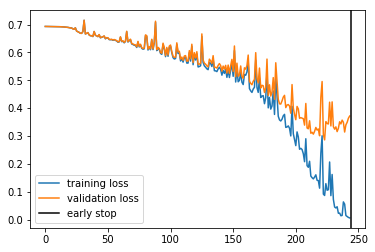

In [24]:
plt.plot(range(len(train_losses)), train_losses, label='training loss')
plt.plot(range(len(valid_losses)), valid_losses, label='validation loss')
# for e in :
#     plt.axvline(x=e, label='learning rate change' if e==0 else None, color='green')
plt.axvline(x=best_epoch, label='early stop', color='black')
plt.legend()
plt.show()

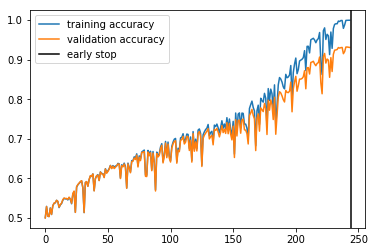

In [25]:
plt.plot(range(len(train_accs)), train_accs, label='training accuracy')
plt.plot(range(len(valid_accs)), valid_accs, label='validation accuracy')
# for e in result['real_epochs']:
#     plt.axvline(x=e, label='learning rate change' if e==0 else None, color='green')
plt.axvline(x=best_epoch, label='early stop', color='black')
plt.legend()
plt.show()

## Generate submission

In [39]:
split = 10
submission = torch.Tensor(submission).float()
step = int(len(submission) / split)
y = []
prob = []
for i in range(0, len(submission), step):
    batch = torch.Tensor(submission[i : i + step]).float()
    batch = batch.view(-1, 3, 64, 64)
    batch = batch.cuda()

    proba = net.forward(batch)
    y_pred = proba.max(1)[1].cpu()
    y += list(map(int, y_pred))
    prob += list(nn.Softmax(proba.cpu(), dim=1))

y = pd.DataFrame(y)
y.index.name = "id"
y.columns = ["label"]
y = y.replace(0, "Cat")
y = y.replace(1, "Dog")
y.index += 1
y.to_csv("submission.csv")

## Question 3

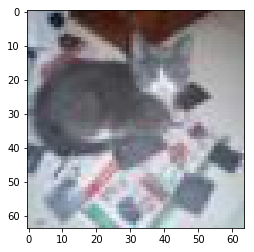

KeyError: 55

In [40]:
missclassified = 55
imgplot = plt.imshow(submission[missclassified])
plt.show()
print(y[missclassified])
print(prob[missclassified])

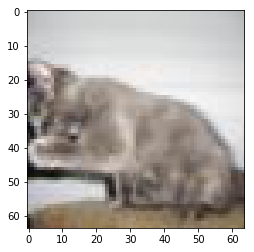

KeyError: 100

In [41]:
hesitation = 100
imgplot = plt.imshow(submission[hesitation])
plt.show()
print(y[hesitation])
print(prob[hesitation])